Resnet Implementation

In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import modal
from modal import Image

In [5]:
RANDOM = 69

In [6]:
# load and preprocess data
data = pd.read_csv('dataset/fer2013.csv')
width, height = 48, 48
datapoints = data['pixels'].tolist()
faces = []
for pixel_sequence in datapoints:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = data['emotion'].values

In [7]:
emotion_labels = ["angry", "disgust", "fear", "happy", "sad", "suprise", "neutral"]

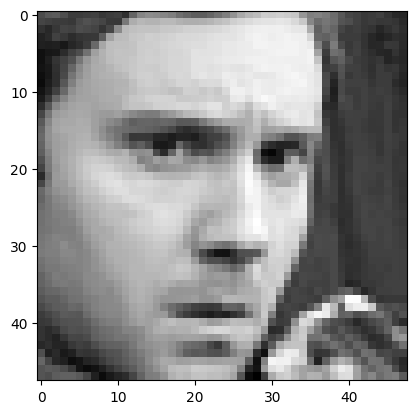

Emotion: angry


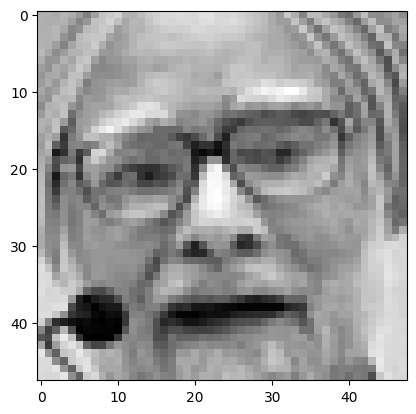

Emotion: angry


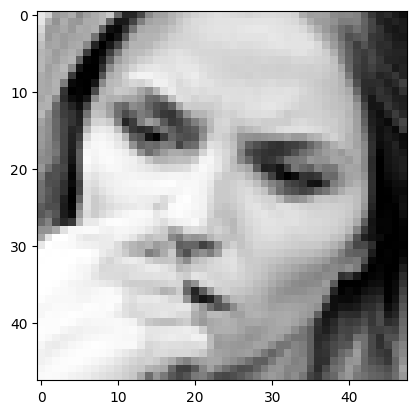

Emotion: fear


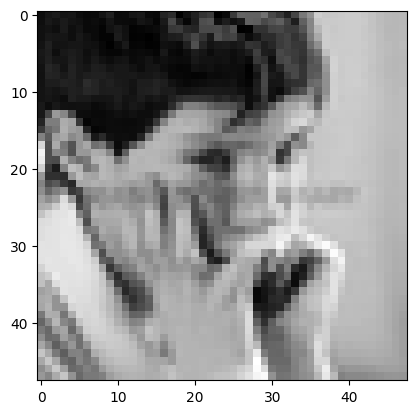

Emotion: sad


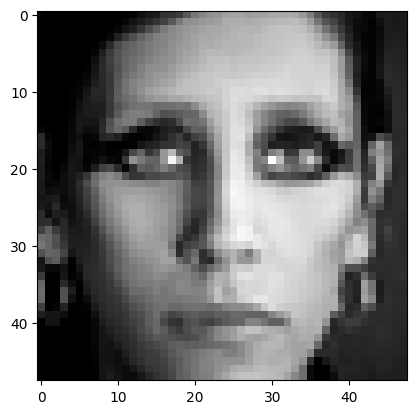

Emotion: neutral


In [8]:
for i in range(5):
    plt.imshow(faces[i].squeeze(), cmap='gray')
    plt.show()

    print(f"Emotion: {emotion_labels[emotions[i]]}")

In [9]:
# config 
train_ratio = 0.8
eval_ratio  = 0.1
test_ratio  = 0.1

# First, split the data into training and remaining sets
x_train, x_rem, y_train, y_rem = train_test_split(faces, emotions, train_size=0.8, stratify=emotions, random_state=RANDOM)

# Then, split the remaining data into testing and evaluation sets
x_test, x_eval, y_test, y_eval = train_test_split(x_rem, y_rem, train_size=0.5, stratify=y_rem, random_state=RANDOM)

# We need to oversample minority classes to prevent bias in the model
unique_classes = np.unique(y_train)

faces_by_class = [x_train[y_train == label] for label in unique_classes]
emotions_by_class = [y_train[y_train == label] for label in unique_classes]

# Find the minimum and maximum number of examples in any class
max_examples = max(len(face_class) for face_class in faces_by_class)
min_exmaples = min(len(face_class) for face_class in faces_by_class)

print(f"Maximum examples: {max_examples}")
print(f"Minimum examples: {min_exmaples}")

# Oversample the minority classes
oversampled_faces    = []
oversampled_emotions = []

def getResampleIndices(num_to_sample, class_len):
    samples = []
    sample_index = 0
    while num_to_sample > 0:
        if sample_index >= class_len:
            sample_index = 0
        samples.append(sample_index)
        sample_index += 1
        num_to_sample -= 1
    
    return samples

for face_class, emotion_class in zip(faces_by_class, emotions_by_class):
    print("-" * 25)
    print(f"Emotion: {emotion_labels[emotion_class[0]]}")
    print(f"Examples: {face_class.shape}")

    num_to_sample = max_examples - face_class.shape[0]
    print(f"Num to sample: {num_to_sample}")

    resample_map = getResampleIndices(num_to_sample, face_class.shape[0])
    resampled_faces = face_class[resample_map]
    resampled_emotions = emotion_class[resample_map]
    print(f"Resamples: {resampled_faces.shape}")

    final_faces = np.concatenate([face_class, resampled_faces])
    final_emotions = np.concatenate([emotion_class, resampled_emotions])
    print(f"Final: {final_faces.shape}")

    oversampled_faces.append(final_faces)
    oversampled_emotions.append(final_emotions)


Maximum examples: 7191
Minimum examples: 438
-------------------------
Emotion: angry
Examples: (3962, 48, 48, 1)
Num to sample: 3229
Resamples: (3229, 48, 48, 1)
Final: (7191, 48, 48, 1)
-------------------------
Emotion: disgust
Examples: (438, 48, 48, 1)
Num to sample: 6753
Resamples: (6753, 48, 48, 1)
Final: (7191, 48, 48, 1)
-------------------------
Emotion: fear
Examples: (4097, 48, 48, 1)
Num to sample: 3094
Resamples: (3094, 48, 48, 1)
Final: (7191, 48, 48, 1)
-------------------------
Emotion: happy
Examples: (7191, 48, 48, 1)
Num to sample: 0
Resamples: (0, 48, 48, 1)
Final: (7191, 48, 48, 1)
-------------------------
Emotion: sad
Examples: (4861, 48, 48, 1)
Num to sample: 2330
Resamples: (2330, 48, 48, 1)
Final: (7191, 48, 48, 1)
-------------------------
Emotion: suprise
Examples: (3202, 48, 48, 1)
Num to sample: 3989
Resamples: (3989, 48, 48, 1)
Final: (7191, 48, 48, 1)
-------------------------
Emotion: neutral
Examples: (4958, 48, 48, 1)
Num to sample: 2233
Resamples: (

In [10]:
# We need to split our dataset into training, eval, and test splits
x_train = np.concatenate(oversampled_faces)
y_train = np.concatenate(oversampled_emotions)

# transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

x_train = np.array([transform(x_train[i]) for i in range(x_train.shape[0])])
x_eval = np.array([transform(x_eval[i]) for i in range(x_eval.shape[0])])
x_test = np.array([transform(x_test[i]) for i in range(x_test.shape[0])])

print(f"Train: {x_train.shape}")
print(f"Eval: {x_eval.shape}")
print(f"Test: {x_test.shape}")

Train: (50337, 1, 48, 48)
Eval: (3589, 1, 48, 48)
Test: (3589, 1, 48, 48)


In [11]:
# step to make sure no data leakage :(
    
# Flatten the face data
X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat = x_test.reshape(x_test.shape[0], -1)
X_eval_flat = x_eval.reshape(x_eval.shape[0], -1)

# Concatenate the datasets
X_combined = np.concatenate((X_train_flat, X_test_flat, X_eval_flat), axis=0)
dataset_labels = np.concatenate((np.full(X_train_flat.shape[0], 'train'),
                                 np.full(X_test_flat.shape[0], 'test'),
                                 np.full(X_eval_flat.shape[0], 'eval')))

# Find duplicate faces
unique_faces, face_counts = np.unique(X_combined, axis=0, return_counts=True)
duplicate_indices = np.where(face_counts > 1)[0]

# Analyze the duplicates
if len(duplicate_indices) > 0:
    print("Duplicates found:")
    for idx in duplicate_indices:
        duplicate_face = unique_faces[idx]
        duplicate_indices = np.where((X_combined == duplicate_face).all(axis=1))[0]
        duplicate_labels = dataset_labels[duplicate_indices]
        print(f"Duplicate face: {duplicate_face}")
        print(f"Original datasets: {duplicate_labels}")
else:
    print("No duplicates found.")
"""
the goddamn function is silly, it only checks duplicates
basically if the 'Original datasets:' part goes across train, test, eval
then you know ur stuff is fucked
otherwise ur good bro
happy coding
"""

KeyboardInterrupt: 

In [12]:
# i did not even out eval and test ... why are we? just gonna test over same pics, whats the point
print(np.bincount(y_eval))

[496  54 512 899 608 400 620]


In [14]:
# define data transformations
# train_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

# data loaders!
train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))

eval_dataset = torch.utils.data.TensorDataset(torch.tensor(x_eval), torch.tensor(y_eval))


In [20]:
# GPU acceleration
stub = modal.Stub(name="resnet")

image = (
    Image.debian_slim(python_version="3.12.1")
    .pip_install(
        "torch==2.2.1",
        "torchvision==0.17.1",
    )
) 

@stub.function(
    gpu="any",
    image=image,
)
def train(train_loader, eval_loader, model, criterion, optimizer):
    print("WE HAVE BEGUN!")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def run_epoch():
        model.train()

        total_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss

        return total_loss / len(train_loader)

    def calculate_accuracy():
        model.eval()

        correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in eval_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                correct += torch.sum(preds == labels) # there could be something wrong with this
                total_samples += inputs.size(0)

        return (correct, total_samples)
    
    epoch = 1
    while epoch <= 20:
        correct, total_samples = calculate_accuracy()
        loss = run_epoch()

        print("-"*25)
        print(f"Epoch: {epoch}")
        print(f"Loss: {loss}")
        print(f"Correct: {correct}")
        print(f"Total: {total_samples}")

        epoch += 1
    
    model.to('cpu')
    return model  

In [21]:
@stub.function(
    gpu="any",
    image=image,
)
def forward(inputs, model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()

    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.max(outputs, 1)

        return preds, features

In [22]:
# define the model
model = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=7)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

In [26]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

eval_loader = DataLoader(eval_dataset, batch_size=len(eval_dataset), shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

if os.path.exists('model_state_dict.pth'):
    model.load_state_dict(torch.load("model_state_dict.pth"))
    print("Model loaded from file.")
else:
    print("Training model...") # if want to retrain, change path name or delete file
    with stub.run():
        model = train.remote(train_loader, eval_loader, model, criterion, optimizer)

        model.to('cpu')

        torch.save(model.state_dict(), 'model_state_dict.pth')

Model loaded from file.


In [28]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def extract_features(model, inputs):
    features = {}
    def hook_fn(module, input, output):
        features['last_conv'] = output.detach()
    
    model.layer4[-1].register_forward_hook(hook_fn)
    _ = model(inputs)
    return features['last_conv']

# DO NOT RUN ON CPU LMFAOOOOO
with stub.run():
    the_thing_we_trained_on = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    features = []
    labels = []
    correct = 0
    total_samples = 0
    for inputs, labels in the_thing_we_trained_on:
        # preds = forward.remote(inputs, trained_model) # mad about hydration
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            features = extract_features(model, inputs)
        correct = torch.sum(preds == labels)
        features.append(preds.cpu().numpy())
        labels.append(labels.numpy())

        print(correct)
        print(len(labels))

/Users/kadijaismail/miniconda3/envs/EmotionRecML/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

✓ Initialized. View run at https://modal.com/kadijaismail112/apps/ap-ICln9DT1ph7naIohDiIS8M

✓ Created objects.
├── 🔨 Created train.
└── 🔨 Created forward.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the features
pca_features = PCA(n_components=2).fit_transform(features.reshape(features.shape[0], -1))
tsne_features = TSNE(n_components=2).fit_transform(features.reshape(features.shape[0], -1))

# Visualize the t-SNE or PCA results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE Visualization')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.title('PCA Visualization')
plt.show()